# Week 6 : Artificial neural network in PyTorch
```
- Machine Learning, Innopolis University (Fall semester 2024)
- Instructors: Adil Khan & Gcinizwe Dlamini
```
<hr>

In this lab, you will practice simple deep learning model in Pytorch.
```
Lab Plan
1. Theoretical issues with ANNs
2. Deep learning frameworks
3. Introduction to Pytorch : Linear Regression with Pytorch
3. Simple ANN model for classification
4. Training ANNs
```

<hr>


## 1. Theoretical issues
Ordinary fully connected neural nets consists of Dense layers, activations, and output layer.

1. What's the difference between deep learning and normal machine learning?
2. How does a neural network with no hidden layers and one output neuron compare to a logistic/linear regression?
3. Can the perceptron find a non-linear decision boundary?
4. In multi-hidden layers network, what's the need of non-linear activation function?
5. Is random weight assignment better than assigning same weights to the units in the hidden layer.
---

## 2. Deep learning framework : PyTorch

Getting started with Pytorch

## 2.1 Linear Regression with Numpy

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sqlalchemy import create_engine, text

In [3]:
QUERY = """
select
    order_history.order_id,
    order_history.STATUS_ID,
    start_prepare.VALUE start_prepare_time,
    order_ready.VALUE order_ready_time,
    sale_basket.store_id,
    sale_basket.product_id
from order_history
inner join main.order_props_value order_ready on order_history.order_id = order_ready.order_id and order_ready.ORDER_PROPS_ID = 95
inner join main.order_props_value start_prepare on order_history.order_id = start_prepare.order_id and start_prepare.ORDER_PROPS_ID = 97
inner join order_busket AS sale_basket ON sale_basket.order_id = order_history.order_id
where sale_basket.store_id = 5863
"""

session_engine = create_engine('sqlite:////Users/dayveed/VscodeProjects/ML_labs/Assignment_1/F24.ML.Assignment.One.data.db')


with session_engine.connect() as conn:
    assignment_data = pd.read_sql_query(sql=text(QUERY), con=conn)

for column in ['order_ready_time','start_prepare_time']:
  assignment_data[column] = pd.to_datetime(assignment_data[column], errors="coerce")


assignment_data.dropna(axis=0, inplace=True)
assignment_data.sort_values(by='start_prepare_time', inplace=True)
assignment_data["prep_time"] = (assignment_data.order_ready_time - assignment_data.start_prepare_time).dt.seconds // 60

In [4]:
def generate_data(size=100, train_ratio=0.8, data_type='random'):
  indices = np.arange(size)
  if data_type == 'random':
    # Generate random x values and corresponding y values with added noise
    x = np.random.rand(size, 1)
    y = 3 + 2.5 * x + 0.1 * np.random.randn(size, 1)

    # Shuffle the indices to randomize the data
    np.random.shuffle(indices)

  else:
    tot_items = assignment_data.groupby("order_id").apply(lambda x: len(x)).reset_index().rename(columns={0: 'tot_items'})
    prep_time = assignment_data.drop_duplicates(subset=['order_id'])[['order_id', 'prep_time']]
    data = pd.merge(left=tot_items, right=prep_time, on='order_id').drop('order_id', axis=1).reset_index(drop=True)
    x = data['tot_items'].values[:size]
    y = data['prep_time'].values[:size]
  # Split the indices based on the train-validation ratio
  split_idx = int(size * train_ratio)
  train_indices = indices[:split_idx]
  val_indices = indices[split_idx:]

  # Generate train and validation datasets
  x_train, y_train = x[train_indices], y[train_indices]
  x_val, y_val = x[val_indices], y[val_indices]

  return x_train, y_train, x_val, y_val

## Generate Dataset

In [5]:
import numpy as np
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate data
x_train, y_train, x_val, y_val = generate_data(data_type='random')

# Reshape x_train for sklearn
x_train_reshaped = x_train.reshape(-1, 1)

# Fit the linear regression model
model = LinearRegression()
model.fit(x_train_reshaped, y_train)

# Make predictions
y_pred = model.predict(x_train_reshaped)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_train, y_pred)

# Create a DataFrame for easier plotting
data = {
    'X Values': x_train.flatten(),  # Flatten in case it's a 2D array
    'Y Values': y_train.flatten(),   # Flatten in case it's a 2D array
    'Predicted Values': y_pred.flatten()
}

# Create the scatter plot for training data
fig = px.scatter(data, x='X Values', y='Y Values',
                 title=f'Training Data with Linear Regression Prediction (MSE: {mse:.4f})',
                 labels={'X Values': 'X Values', 'Y Values': 'Y Values'},
                 opacity=0.7, color_discrete_sequence=['blue'])

# Add model predictions as a line
fig.add_scatter(x=data['X Values'], y=data['Predicted Values'],
                 mode='lines', name='Linear Regression Prediction',
                 line=dict(color='red', width=2))

# Show the plot
fig.show()


## Gradient Descent algorithm

Gradient descent consist of 3 basic steps :

1. **Compute the Loss**

$$ \hat{y} = a + bx + \epsilon $$

$$ \text{MSE} = \frac{1}{N} \sum_{i} (y_i - \hat{y}_i)^2 $$

$$ \text{MSE} = \frac{1}{N} \sum_{i} (y_i - a - bx_i)^2 $$

2. **Compute the Gradients** : A gradient is a partial derivative. Using the chain rule the final expression came to be :

$$\frac{\partial \text{MSE}}{\partial a} = \frac{\partial \text{MSE}}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial a} = -2 * \frac{1}{N} \sum_{i} (y_i - \hat{y}_i)$$

$$\frac{\partial \text{MSE}}{\partial b} = \frac{\partial \text{MSE}}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial b} = -2 * \frac{1}{N} \sum_{i} x_i(y_i - \hat{y}_i)$$

3. **Update the Parameters**

$$a = a - \alpha \frac{\partial \text{MSE}}{\partial a}$$

$$b = b - \alpha \frac{\partial \text{MSE}}{\partial b}$$

4. Repeat step 1 to 3 till convergence is reached

## Linear Regression model training

In [6]:
# Initialize parameters "a" and "b" randomly
a = np.random.randn(1)
b = np.random.randn(1)

print(f"Initial values of [a, b]: [{a[0]:.4f}, {b[0]:.4f}]")

learning_rate = 1e-1  # Learning rate
n_epochs = 100  # Number of iterations

for epoch in range(n_epochs):
    # Step 1: Compute predicted values (y_hat)
    y_hat = a + b * x_train 

    # Step 2: Compute error and Mean Squared Error (MSE) Loss
    error = y_train -  y_hat
    loss = np.mean(error ** 2)

    # Step 3: Compute gradients for parameters "a" and "b"
    a_grad = -2 * np.mean(error)
    b_grad = -2 * np.mean(x_train * error)

    # Step 4: Update parameters using the gradients and learning rate
    a -= learning_rate * a_grad
    b -= learning_rate * b_grad

    # Optional: Print loss every 100 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.6f}")

# Final values of parameters after training
print(f"Final values of [a, b]: [{a[0]:.4f}, {b[0]:.4f}]")

Initial values of [a, b]: [-0.8503, 0.1271]
Epoch 0: Loss = 25.305032
Epoch 10: Loss = 0.102156
Epoch 20: Loss = 0.017309
Epoch 30: Loss = 0.015371
Epoch 40: Loss = 0.014103
Epoch 50: Loss = 0.013141
Epoch 60: Loss = 0.012411
Epoch 70: Loss = 0.011856
Epoch 80: Loss = 0.011434
Epoch 90: Loss = 0.011114
Final values of [a, b]: [3.0212, 2.4591]


## Pytorch basics

### Tensors

* How to create a Tensor
* Operations on tensors
* Data types for Tensors### Create a Tensor

Create tensors from Numpy then see what operations can be applied.
**Note:** By default a tensor resides in cpu but can be sent to the GPU for faster computations

In [7]:
import torch

# Check device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert numpy arrays to tensors and move to the selected device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Print type and device information
print(f"Original type: {type(x_train)}")
print(f"Tensor type: {x_train_tensor.type()}, Device: {x_train_tensor.device}")

Original type: <class 'numpy.ndarray'>
Tensor type: torch.FloatTensor, Device: cpu


## Linear Regression (Numpy -> PyTorch)

In [8]:
criterion = torch.nn.MSELoss()

In [19]:
import torch

# Initialize parameters "a" and "b" on the correct device
a = torch.randn(1, device=device, requires_grad=True)
b = torch.randn(1, device=device, requires_grad=True)

model =  torch.nn.Sequential(torch.nn.Linear(1,1, bias=True)).to(device)
# optimizer = torch.optim.SGD([a,b], lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Convert numpy arrays to tensors and move to the selected device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

learning_rate = 1e-1  # Learning rate
n_epochs = 100  # Number of iterations

for epoch in range(n_epochs):
    # Step 1: Compute predicted values (yhat)
    yhat = a + b * x_train_tensor

    # Step 2: Compute error and MSE loss
    # error = y_train_tensor - y_hat
    # loss = torch.mean(error ** 2)
    loss = criterion(y_train_tensor, yhat)

    # Step 3: Compute gradients (partial derivatives for "a" and "b")
    loss.backward()
    # a_grad =  -2 * error.mean()
    # b_grad =  -2 * (x_train_tensor * error).mean()

    # Step 4: Update parameters using gradients and learning rate
    # with torch.no_grad():
    #     a -= learning_rate * a.grad
    #     b -= learning_rate * b.grad
    optimizer.step()

    # a.grad = None
    # b.grad = None

    # Optional: Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Print final values of "a" and "b"
print(f"Final values of [a, b]: [{a.item():.4f}, {b.item():.4f}]")

Epoch 0: Loss = 18.906734
Epoch 10: Loss = 18.906734
Epoch 20: Loss = 18.906734
Epoch 30: Loss = 18.906734
Epoch 40: Loss = 18.906734
Epoch 50: Loss = 18.906734
Epoch 60: Loss = 18.906734
Epoch 70: Loss = 18.906734
Epoch 80: Loss = 18.906734
Epoch 90: Loss = 18.906734
Final values of [a, b]: [-0.5426, 0.8671]


### 2.1 Feed Forward Neural Network
An artificial neural network wherein connections between the nodes do not form a cycle.
<!--![alt text](https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif)
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Artificial_neural_network.svg/2294px-Artificial_neural_network.svg.png)-->

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Artificial_neural_network.svg/2294px-Artificial_neural_network.svg.png" width="1000"/>
</div>


### Model Design in Pytorch
we have three simple parts that we need to build:
1. Data Loading process.
2. Model building.
3. the training loops.

<strong>Data Loading</strong>

Data Loading in pytorch is very easy and broken into 3 steps:
1. Data Source
2. Data Transformations
3. Data Loader



## 3. Loading data

Pytorch uses data loading utility which is called `DataLoader` that supports:
automatic batching, transformation, single- and multi-process data loading and more..

In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set batch sizes
batch_size = 32
test_batch_size = 100

# Define data transformations: convert to tensor and normalize
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std of MNIST dataset
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=data_transforms)

# Create DataLoader for training and testing datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Print to verify data loading
print(f"Training data: {len(train_loader.dataset)} samples")
print(f"Test data: {len(test_loader.dataset)} samples")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:19<00:00, 518702.97it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 193200.41it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 618541.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1911743.98it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training data: 60000 samples
Test data: 10000 samples


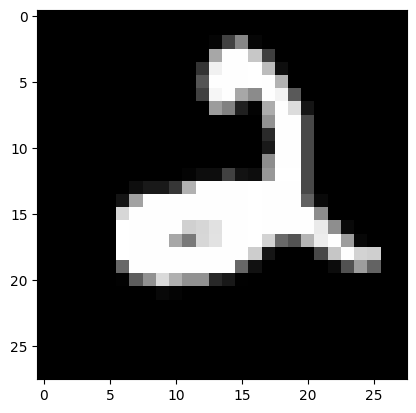

In [13]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.imshow(images[0].reshape(28,28), cmap="gray")

## 4. Model building
1. Defining components: <br/>
This step is done in the constructor, where you will define the layers that will be used accordingly in the next step.
2. Network flow: <br/>
This step is done in the forward function. Where you will get the input batch as an argument then you will use the defined layers in the previous step to define the flow of the network then you will return the output batch.


Pytorch is a dynamic framework, where you can use primitive python keywords with it.
You can use if and while statements. Also, it can accepts and returns more than one batch.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)  # First hidden layer
        self.fc2 = nn.Linear(500, 250)       # Second hidden layer
        self.fc3 = nn.Linear(250, 100)       # Third hidden layer
        self.fc4 = nn.Linear(100, 10)        # Output layer (10 classes)
        self.dropout = nn.Dropout(0.5)       # Dropout layer for regularization

    def forward(self, x):
        # Flatten the input
        x = x.view(-1, 28 * 28)
        # Pass through the first layer and apply ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout
        x = self.dropout(x)
        # Pass through the second layer and apply ReLU activation
        x = F.relu(self.fc2(x))
        # Apply dropout
        x = self.dropout(x)
        # Pass through the third layer and apply ReLU activation
        x = F.relu(self.fc3(x))
        # Pass through the output layer with log softmax
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

# Check for CUDA availability
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

## 5. Training loops
After that we should define the loops over tha batches and run the training on.

In [ ]:
# Define training params
epochs = 5
lr = 0.01
momentum = 0.5

## 5.1 Define the training procedure

In [ ]:
import torch

def train(model, device, train_loader, optimizer, epoch, criterion=torch.nn.functional.nll_loss):
    model.train()  # Set model to training mode
    total_loss = 0  # To track total loss for the epoch

    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and targets to the specified device (CPU/GPU)
        data, target = data.to(device), target.to(device)

        # Reset gradients from the previous iteration
        optimizer.zero_grad()

        # Forward pass: Compute model predictions
        output = model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backward pass: Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate loss for the entire epoch
        total_loss += loss.item()

    # Print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f'====> Epoch: {epoch} Average Training loss: {avg_loss:.6f}')


## 5.2 Define the evaluation procedure

In [ ]:
def test(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for data, target in test_loader:
            # Move the data and target tensors to the specified device (CPU or GPU)
            data, target = data.to(device), target.to(device)

            # Get the model's output predictions
            output = model(data)

            # Compute the loss using negative log likelihood
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum up batch loss

            # Get the index of the max log-probability for predicted classes
            pred = output.argmax(dim=1, keepdim=True)

            # Count the number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average loss across the entire test dataset
    test_loss /= len(test_loader.dataset)

    # Print the average loss and accuracy
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


## 5.3 Training Model

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

====> Epoch: 1 Average Training loss: 0.680782
Test set: Average loss: 0.2062, Accuracy: 9361/10000 (94%)

====> Epoch: 2 Average Training loss: 0.248885
Test set: Average loss: 0.1327, Accuracy: 9583/10000 (96%)

====> Epoch: 3 Average Training loss: 0.181109
Test set: Average loss: 0.1066, Accuracy: 9672/10000 (97%)

====> Epoch: 4 Average Training loss: 0.149861
Test set: Average loss: 0.0908, Accuracy: 9719/10000 (97%)

====> Epoch: 5 Average Training loss: 0.130228
Test set: Average loss: 0.0852, Accuracy: 9738/10000 (97%)



## 6. Save model

In [ ]:
model_save_path = 'model.pth'  # Specify the filename for saving the model
torch.save(model.state_dict(), model_save_path)  # Save the model's state dict
print(f'Model saved to {model_save_path}')

Model saved to model.pth


## <center>Self-practice <center>

Using Dataset from assignment 1
1. Define, train and evaluate an ANN for Regression and Classification
1. Plot the loss and accuracy of the model for each training iteration
    
ANN should be implemented in PyTorch